In [27]:
import warnings
import time
import sys
import datetime
import joblib
import lightgbm as lgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import accuracy_score

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

In [28]:
df_train = pd.read_csv('../Kaggle-data/processed/train-processed_0624.csv')
df_test = pd.read_csv('../Kaggle-data/processed/test-processed_0624.csv')

In [29]:
# 特徴量の情報
features = [c for c in df_train.columns if c not in ['card_id']]
categorical_feats = ['feature_1','feature_2', 'feature_3',]

In [30]:
df_train

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time,quarter,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_product,feature_mean,feature_max,feature_min,feature_var,authorized_ratio,cat_1_mean,installments_mean,installments_max,installments_min,month_lag_mean,month_lag_max,month_lag_min,purchase_amount_mean,purchase_amount_max,purchase_amount_min,cat_2_1_mean,cat_2_2_mean,cat_2_3_mean,cat_2_4_mean,cat_2_5_mean,cat_3_A_mean,cat_3_B_mean,cat_3_C_mean,purchase_freq
0,2017-06-01,C_ID_92a2005557,1.00,0.5,1.0,-0.820283,0.107268,2,0.157759,0.071512,0.107268,0.121699,0.080192,0.126531,1.000000,1.0,1.000000,1.00,1.0,0.868517,0.952619,0.000000,0.036203,0.083333,0.090909,0.639443,1.000000,0.416667,3.544876e-07,4.997500e-07,0.000256,0.989399,0.0,0.000000,0.000000,0.010601,0.985866,0.014134,0.000000,0.096464
1,2017-01-01,C_ID_3d0044924f,0.75,0.0,0.0,0.392913,0.173380,1,0.203992,0.057793,0.000000,0.057441,0.021668,0.000000,0.500000,0.0,0.500000,0.75,0.0,0.868517,0.968129,0.087079,0.161156,0.833333,0.000000,0.535782,1.000000,0.083333,4.528911e-07,8.942500e-07,0.000154,0.912921,0.0,0.000000,0.000000,0.000000,0.000000,0.792135,0.202247,0.121524
2,2016-08-01,C_ID_d639edf6cd,0.25,0.5,0.0,0.688056,0.240368,3,0.141404,0.160245,0.000000,0.017180,0.033270,0.000000,0.333333,0.0,0.333333,0.25,0.0,0.333333,0.953116,0.000000,0.035047,0.000000,0.090909,0.289328,1.000000,0.000000,2.107272e-07,9.975000e-08,0.000564,0.090909,0.0,0.000000,0.000000,0.909091,1.000000,0.000000,0.000000,0.014418
3,2017-09-01,C_ID_186d6a6901,0.75,1.0,0.0,0.142495,0.066988,3,0.078815,0.066988,0.000000,0.157456,0.198990,0.000000,0.833333,0.0,0.833333,0.75,0.0,0.868517,1.000000,0.154762,0.121690,0.250000,0.000000,0.712551,1.000000,0.666667,3.189285e-07,3.645000e-07,0.000205,0.142857,0.0,0.000000,0.702381,0.000000,0.000000,0.880952,0.083333,0.028150
4,2017-11-01,C_ID_cdbd2c0db2,0.00,1.0,0.0,-0.159749,0.040280,4,0.011848,0.040280,0.000000,0.062232,0.333943,0.000000,0.333333,0.0,0.333333,0.50,0.0,0.548584,0.969484,0.100592,0.140049,1.000000,0.000000,0.839412,1.000000,0.833333,1.072966e-06,1.320750e-06,0.000000,0.071006,0.0,0.041420,0.781065,0.005917,0.000000,0.946746,0.047337,0.057329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912,2017-09-01,C_ID_963962de2c,0.50,0.5,1.0,-2.740821,0.066988,3,0.059111,0.044658,0.066988,0.116709,0.131145,0.202614,0.666667,0.6,0.666667,0.50,1.0,0.244017,0.912217,0.000000,0.036787,0.083333,0.090909,0.744939,0.923077,0.666667,1.154149e-07,2.875000e-08,0.000154,0.297872,0.0,0.702128,0.000000,0.000000,0.978723,0.021277,0.000000,0.015448
201913,2015-10-01,C_ID_1314773c0b,0.50,0.0,1.0,0.312917,0.373905,4,0.329942,0.124635,0.373905,0.016369,0.007610,0.036300,0.500000,0.3,0.500000,0.50,1.0,0.333333,0.849581,0.000000,0.036750,0.083333,0.090909,0.618155,0.923077,0.000000,1.051927e-07,2.850000e-08,0.000103,1.000000,0.0,0.000000,0.000000,0.000000,0.979167,0.020833,0.000000,0.015791
201914,2017-08-01,C_ID_7666735b3d,0.75,1.0,0.0,0.093494,0.080560,3,0.094784,0.080560,0.000000,0.129996,0.164699,0.000000,0.833333,0.0,0.833333,0.75,0.0,0.868517,0.931237,0.100000,0.137721,0.750000,0.000000,0.631977,0.923077,0.583333,1.165597e-06,1.124750e-06,0.000308,0.055556,0.0,0.755556,0.000000,0.000000,0.000000,0.866667,0.122222,0.030209
201915,2016-07-01,C_ID_73f5a0efd0,0.50,0.5,1.0,-4.676589,0.253940,3,0.224082,0.169294,0.253940,0.026715,0.031249,0.053448,0.666667,0.6,0.666667,0.50,1.0,0.244017,0.933455,0.000000,0.035047,0.000000,0.090909,0.705677,1.000000,0.333333,7.287418e-07,4.997500e-07,0.000513,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.009955


In [31]:
df_test

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,quarter,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_product,feature_mean,feature_max,feature_min,feature_var,authorized_ratio,cat_1_mean,installments_mean,installments_max,installments_min,month_lag_mean,month_lag_max,month_lag_min,purchase_amount_mean,purchase_amount_max,purchase_amount_min,cat_2_1_mean,cat_2_2_mean,cat_2_3_mean,cat_2_4_mean,cat_2_5_mean,cat_3_A_mean,cat_3_B_mean,cat_3_C_mean,purchase_freq
0,2017-04-01,C_ID_0ab67a22ab,0.50,1.0,1.0,0.122059,0.333333,0.114688,0.131778,0.133975,0.055589,0.097223,0.101307,0.833333,0.9,0.833333,0.50,1.0,0.333333,0.642470,0.323944,0.188482,1.000000,0.181818,0.642463,1.000000,0.416667,0.000032,0.000007,0.000619,0.676056,0.0,0.000000,0.000000,0.000000,0.0,0.676056,0.323944,0.012366
1,2017-01-01,C_ID_130fd0cbdd,0.25,1.0,0.0,0.162006,0.000000,0.098397,0.171891,0.000000,0.025955,0.074094,0.000000,0.500000,0.0,0.500000,0.50,0.0,0.548584,0.987843,0.045977,0.108218,0.333333,0.181818,0.214677,1.000000,0.000000,0.000024,0.000008,0.001238,0.000000,0.0,0.011494,0.942529,0.000000,0.0,0.965517,0.034483,0.015233
2,2017-08-01,C_ID_b709037bc5,1.00,0.0,1.0,0.067909,0.666667,0.114947,0.022731,0.080560,0.163878,0.051870,0.168478,0.833333,0.5,0.833333,1.00,1.0,1.000000,0.717949,0.133333,0.320928,0.833333,0.000000,0.770122,0.916667,0.583333,0.000231,0.000024,0.004643,0.066667,0.0,0.000000,0.000000,0.800000,0.0,0.133333,0.666667,0.002330
3,2017-12-01,C_ID_d27d835a9f,0.25,0.0,0.0,0.013759,1.000000,0.012025,0.004606,0.000000,0.195575,0.162879,0.000000,0.166667,0.0,0.166667,0.25,0.0,0.244017,1.000000,0.027778,0.172425,1.000000,0.000000,0.854274,1.000000,0.916667,0.000045,0.000006,0.003095,0.944444,0.0,0.000000,0.000000,0.027778,0.0,0.611111,0.333333,0.006093
4,2015-12-01,C_ID_2b5e3df5c2,1.00,0.0,1.0,0.338216,1.000000,0.508663,0.113208,0.347198,0.033777,0.008545,0.039092,0.833333,0.5,0.833333,1.00,1.0,1.000000,0.790285,0.000000,0.107982,0.333333,0.000000,0.461400,1.000000,0.000000,0.000233,0.000122,0.000000,0.034483,0.0,0.051724,0.913793,0.000000,0.0,0.931034,0.060345,0.020430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123618,2017-10-01,C_ID_7a239d2eda,0.25,0.5,0.0,0.040834,1.000000,0.027799,0.031942,0.000000,0.095839,0.164241,0.000000,0.333333,0.0,0.333333,0.25,0.0,0.333333,0.956533,0.000000,0.019352,0.000000,0.090909,0.762699,0.833333,0.750000,0.000015,0.000002,0.003095,0.041096,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.012724
123619,2017-09-01,C_ID_75ace375ae,0.50,0.0,1.0,0.054150,0.666667,0.055340,0.018125,0.066988,0.116709,0.063300,0.202614,0.500000,0.3,0.500000,0.50,1.0,0.333333,1.000000,0.000000,0.019352,0.000000,0.090909,0.799230,1.000000,0.666667,0.000012,0.000002,0.001238,0.909091,0.0,0.000000,0.000000,0.090909,1.0,0.000000,0.000000,0.001613
123620,2016-09-01,C_ID_21d56d950c,1.00,0.0,1.0,0.216156,0.666667,0.330877,0.072352,0.226795,0.054645,0.015494,0.059846,0.833333,0.5,0.833333,1.00,1.0,1.000000,0.971414,0.081081,0.150504,0.583333,0.000000,0.609695,0.833333,0.250000,0.000124,0.000018,0.009904,0.027027,0.0,0.000000,0.000000,0.891892,0.0,0.675676,0.297297,0.006272
123621,2017-06-01,C_ID_6c46fc5a9d,0.25,0.0,0.0,0.094984,0.333333,0.059348,0.031793,0.000000,0.045360,0.037824,0.000000,0.166667,0.0,0.166667,0.25,0.0,0.244017,0.704468,0.014706,0.170543,0.416667,0.000000,0.755271,0.916667,0.750000,0.000025,0.000005,0.001857,0.058824,0.0,0.926471,0.000000,0.000000,0.0,0.470588,0.500000,0.011828


In [32]:
df_train['first_active_month'] = pd.to_datetime(df_train['first_active_month'])
df_test['first_active_month'] = pd.to_datetime(df_test['first_active_month'])

In [33]:
df_train.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time,quarter,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_product,feature_mean,feature_max,feature_min,feature_var,authorized_ratio,cat_1_mean,installments_mean,installments_max,installments_min,month_lag_mean,month_lag_max,month_lag_min,purchase_amount_mean,purchase_amount_max,purchase_amount_min,cat_2_1_mean,cat_2_2_mean,cat_2_3_mean,cat_2_4_mean,cat_2_5_mean,cat_3_A_mean,cat_3_B_mean,cat_3_C_mean,purchase_freq
0,2017-06-01,C_ID_92a2005557,1.00,0.5,1.0,-0.820283,0.107268,2,0.157759,0.071512,0.107268,0.121699,0.080192,0.126531,1.000000,1.0,1.000000,1.00,1.0,0.868517,0.952619,0.000000,0.036203,0.083333,0.090909,0.639443,1.000000,0.416667,3.544876e-07,4.997500e-07,0.000256,0.989399,0.0,0.00000,0.000000,0.010601,0.985866,0.014134,0.000000,0.096464
1,2017-01-01,C_ID_3d0044924f,0.75,0.0,0.0,0.392913,0.173380,1,0.203992,0.057793,0.000000,0.057441,0.021668,0.000000,0.500000,0.0,0.500000,0.75,0.0,0.868517,0.968129,0.087079,0.161156,0.833333,0.000000,0.535782,1.000000,0.083333,4.528911e-07,8.942500e-07,0.000154,0.912921,0.0,0.00000,0.000000,0.000000,0.000000,0.792135,0.202247,0.121524
2,2016-08-01,C_ID_d639edf6cd,0.25,0.5,0.0,0.688056,0.240368,3,0.141404,0.160245,0.000000,0.017180,0.033270,0.000000,0.333333,0.0,0.333333,0.25,0.0,0.333333,0.953116,0.000000,0.035047,0.000000,0.090909,0.289328,1.000000,0.000000,2.107272e-07,9.975000e-08,0.000564,0.090909,0.0,0.00000,0.000000,0.909091,1.000000,0.000000,0.000000,0.014418
3,2017-09-01,C_ID_186d6a6901,0.75,1.0,0.0,0.142495,0.066988,3,0.078815,0.066988,0.000000,0.157456,0.198990,0.000000,0.833333,0.0,0.833333,0.75,0.0,0.868517,1.000000,0.154762,0.121690,0.250000,0.000000,0.712551,1.000000,0.666667,3.189285e-07,3.645000e-07,0.000205,0.142857,0.0,0.00000,0.702381,0.000000,0.000000,0.880952,0.083333,0.028150
4,2017-11-01,C_ID_cdbd2c0db2,0.00,1.0,0.0,-0.159749,0.040280,4,0.011848,0.040280,0.000000,0.062232,0.333943,0.000000,0.333333,0.0,0.333333,0.50,0.0,0.548584,0.969484,0.100592,0.140049,1.000000,0.000000,0.839412,1.000000,0.833333,1.072966e-06,1.320750e-06,0.000000,0.071006,0.0,0.04142,0.781065,0.005917,0.000000,0.946746,0.047337,0.057329
5,2016-09-01,C_ID_0894217f2f,0.75,0.5,0.0,0.871585,0.226795,3,0.266838,0.151197,0.000000,0.042610,0.035534,0.000000,0.666667,0.0,0.666667,0.75,0.0,0.821367,0.972123,0.027027,0.278164,0.833333,0.181818,0.739134,1.000000,0.583333,1.060020e-06,1.295000e-07,0.002308,0.945946,0.0,0.00000,0.000000,0.027027,0.000000,0.243243,0.756757,0.012015
6,2016-12-01,C_ID_7e63323c00,0.50,0.5,1.0,0.230129,0.186953,4,0.164971,0.124635,0.186953,0.038269,0.044075,0.072600,0.666667,0.6,0.666667,0.50,1.0,0.244017,0.933832,0.000000,0.035047,0.000000,0.090909,0.422892,1.000000,0.000000,1.015604e-07,3.250000e-08,0.000154,0.003774,0.0,0.00000,0.000000,0.996226,1.000000,0.000000,0.000000,0.090285
7,2017-09-01,C_ID_dfa21fc124,0.50,0.5,1.0,2.135850,0.066988,3,0.059111,0.044658,0.066988,0.116709,0.131145,0.202614,0.666667,0.6,0.666667,0.50,1.0,0.244017,0.876226,0.000000,0.035047,0.000000,0.090909,0.796488,1.000000,0.833333,3.756300e-07,1.147500e-07,0.000051,0.280000,0.0,0.00000,0.720000,0.000000,1.000000,0.000000,0.000000,0.007896
8,2017-08-01,C_ID_fe0fdac8ea,0.25,0.0,0.0,-0.065406,0.080560,3,0.047392,0.026853,0.000000,0.062232,0.051870,0.000000,0.166667,0.0,0.166667,0.25,0.0,0.244017,0.757307,0.235294,0.121633,0.166667,0.181818,0.631228,0.923077,0.583333,5.018235e-07,8.225000e-08,0.000000,0.764706,0.0,0.00000,0.000000,0.000000,0.000000,0.941176,0.058824,0.005149
9,2016-08-01,C_ID_bf62c0b49d,0.25,0.5,0.0,0.300062,0.240368,3,0.141404,0.160245,0.000000,0.017180,0.033270,0.000000,0.333333,0.0,0.333333,0.25,0.0,0.333333,0.875515,0.000000,0.037162,0.083333,0.090909,0.482009,1.000000,0.000000,1.997047e-07,6.225000e-08,0.000103,0.991379,0.0,0.00000,0.000000,0.008621,0.974138,0.025862,0.000000,0.039135


In [34]:
df_test.head(10)

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,quarter,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_product,feature_mean,feature_max,feature_min,feature_var,authorized_ratio,cat_1_mean,installments_mean,installments_max,installments_min,month_lag_mean,month_lag_max,month_lag_min,purchase_amount_mean,purchase_amount_max,purchase_amount_min,cat_2_1_mean,cat_2_2_mean,cat_2_3_mean,cat_2_4_mean,cat_2_5_mean,cat_3_A_mean,cat_3_B_mean,cat_3_C_mean,purchase_freq
0,2017-04-01,C_ID_0ab67a22ab,0.50,1.0,1.0,0.122059,0.333333,0.114688,0.131778,0.133975,0.055589,0.097223,0.101307,0.833333,0.9,0.833333,0.50,1.0,0.333333,0.642470,0.323944,0.188482,1.000000,0.181818,0.642463,1.000000,0.416667,0.000032,0.000007,0.000619,0.676056,0.000000,0.000000,0.000000,0.000000,0.0,0.676056,0.323944,0.012366
1,2017-01-01,C_ID_130fd0cbdd,0.25,1.0,0.0,0.162006,0.000000,0.098397,0.171891,0.000000,0.025955,0.074094,0.000000,0.500000,0.0,0.500000,0.50,0.0,0.548584,0.987843,0.045977,0.108218,0.333333,0.181818,0.214677,1.000000,0.000000,0.000024,0.000008,0.001238,0.000000,0.000000,0.011494,0.942529,0.000000,0.0,0.965517,0.034483,0.015233
2,2017-08-01,C_ID_b709037bc5,1.00,0.0,1.0,0.067909,0.666667,0.114947,0.022731,0.080560,0.163878,0.051870,0.168478,0.833333,0.5,0.833333,1.00,1.0,1.000000,0.717949,0.133333,0.320928,0.833333,0.000000,0.770122,0.916667,0.583333,0.000231,0.000024,0.004643,0.066667,0.000000,0.000000,0.000000,0.800000,0.0,0.133333,0.666667,0.002330
3,2017-12-01,C_ID_d27d835a9f,0.25,0.0,0.0,0.013759,1.000000,0.012025,0.004606,0.000000,0.195575,0.162879,0.000000,0.166667,0.0,0.166667,0.25,0.0,0.244017,1.000000,0.027778,0.172425,1.000000,0.000000,0.854274,1.000000,0.916667,0.000045,0.000006,0.003095,0.944444,0.000000,0.000000,0.000000,0.027778,0.0,0.611111,0.333333,0.006093
4,2015-12-01,C_ID_2b5e3df5c2,1.00,0.0,1.0,0.338216,1.000000,0.508663,0.113208,0.347198,0.033777,0.008545,0.039092,0.833333,0.5,0.833333,1.00,1.0,1.000000,0.790285,0.000000,0.107982,0.333333,0.000000,0.461400,1.000000,0.000000,0.000233,0.000122,0.000000,0.034483,0.000000,0.051724,0.913793,0.000000,0.0,0.931034,0.060345,0.020430
5,2017-07-01,C_ID_5814b4f13c,1.00,0.0,1.0,0.081669,0.666667,0.134988,0.027336,0.094133,0.139452,0.043736,0.144186,0.833333,0.5,0.833333,1.00,1.0,1.000000,0.751131,0.058824,0.125791,0.333333,0.181818,0.706374,0.916667,0.500000,0.000150,0.000008,0.034664,0.588235,0.000000,0.294118,0.000000,0.000000,0.0,0.823529,0.176471,0.002688
6,2017-10-01,C_ID_a1b3c75277,0.00,0.5,0.0,0.040834,1.000000,0.011896,0.031942,0.000000,0.045154,0.164241,0.000000,0.166667,0.0,0.166667,0.25,0.0,0.244017,1.000000,0.017544,0.136231,0.500000,0.000000,0.803826,1.000000,0.750000,0.000075,0.000011,0.012999,0.017544,0.157895,0.000000,0.000000,0.807018,0.0,0.596491,0.333333,0.009857
7,2017-02-01,C_ID_f7cada36d3,0.50,0.0,1.0,0.148247,0.000000,0.137574,0.049621,0.159807,0.045709,0.023894,0.084932,0.500000,0.3,0.500000,0.50,1.0,0.333333,0.735577,0.000000,0.019352,0.000000,0.090909,0.497962,0.750000,0.083333,0.000012,0.000003,0.001238,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.003226
8,2017-07-01,C_ID_9d2bc8dfc4,0.75,1.0,0.0,0.081669,0.666667,0.107189,0.091220,0.000000,0.110455,0.140297,0.000000,0.833333,0.0,0.833333,0.75,0.0,0.868517,0.647436,0.473684,0.237237,1.000000,0.181818,0.587342,1.000000,0.500000,0.000061,0.000017,0.002786,0.070175,0.000000,0.438596,0.000000,0.017544,0.0,0.649123,0.350877,0.009857
9,2016-03-01,C_ID_6d8dba8475,1.00,0.0,1.0,0.297825,0.000000,0.449832,0.099688,0.307356,0.038872,0.010242,0.044160,0.833333,0.5,0.833333,1.00,1.0,1.000000,0.907220,0.000000,0.103043,0.166667,0.181818,0.567898,1.000000,0.416667,0.000027,0.000006,0.003095,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.982456,0.017544,0.009857


In [35]:
# ターゲットが通常値か異常値かを判断する2値分類


In [36]:
# targetの値を正規化
scaler_for_train = MinMaxScaler()
df_train['target'] = scaler_for_train.fit_transform(df_train['target'].values.reshape(-1, 1))
joblib.dump(scaler_for_train, 'scaler_for_train.pkl')

# 特徴量とターゲットの分割
X = df_train.drop(['card_id', 'target', 'first_active_month'], axis=1)
y = df_train['target']

# 訓練データとテストデータの分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBMのデータセットに変換
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

# ハイパーパラメータの設定
params = {
    'boosting_type': 'gbdt',         # 勾配ブースティングのタイプ
    'objective': 'regression',       # 目的関数：回帰
    'metric': 'rmse',                # 評価指標：平均二乗誤差の平方根
    'num_leaves': 50,                # 木の葉の最大数
    'learning_rate': 0.05,           # 学習率
    'feature_fraction': 0.95,         # 各木で使用する特徴量の割合
    'bagging_fraction': 0.8,         # バギングの割合
    'bagging_freq': 5,               # バギングの頻度
    'verbose': 1                     # 学習の進捗表示
}

# params = {'num_leaves': 111,
#          'min_data_in_leaf': 149,
#          'objective':'regression',
#          'max_depth': 9,
#          'learning_rate': 0.005,
#          "boosting": "gbdt",
#          "feature_fraction": 0.7522,
#          "bagging_freq": 1,
#          "bagging_fraction": 0.7083 ,
#          "bagging_seed": 11,
#          "metric": 'rmse',
#          "lambda_l1": 0.2634,
#          "random_state": 133,
#          "verbosity": -1}

In [37]:
df_train

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time,quarter,days_feature1,days_feature2,days_feature3,days_feature1_ratio,days_feature2_ratio,days_feature3_ratio,feature_sum,feature_product,feature_mean,feature_max,feature_min,feature_var,authorized_ratio,cat_1_mean,installments_mean,installments_max,installments_min,month_lag_mean,month_lag_max,month_lag_min,purchase_amount_mean,purchase_amount_max,purchase_amount_min,cat_2_1_mean,cat_2_2_mean,cat_2_3_mean,cat_2_4_mean,cat_2_5_mean,cat_3_A_mean,cat_3_B_mean,cat_3_C_mean,purchase_freq
0,2017-06-01,C_ID_92a2005557,1.00,0.5,1.0,0.632986,0.107268,2,0.157759,0.071512,0.107268,0.121699,0.080192,0.126531,1.000000,1.0,1.000000,1.00,1.0,0.868517,0.952619,0.000000,0.036203,0.083333,0.090909,0.639443,1.000000,0.416667,3.544876e-07,4.997500e-07,0.000256,0.989399,0.0,0.000000,0.000000,0.010601,0.985866,0.014134,0.000000,0.096464
1,2017-01-01,C_ID_3d0044924f,0.75,0.0,0.0,0.656689,0.173380,1,0.203992,0.057793,0.000000,0.057441,0.021668,0.000000,0.500000,0.0,0.500000,0.75,0.0,0.868517,0.968129,0.087079,0.161156,0.833333,0.000000,0.535782,1.000000,0.083333,4.528911e-07,8.942500e-07,0.000154,0.912921,0.0,0.000000,0.000000,0.000000,0.000000,0.792135,0.202247,0.121524
2,2016-08-01,C_ID_d639edf6cd,0.25,0.5,0.0,0.662455,0.240368,3,0.141404,0.160245,0.000000,0.017180,0.033270,0.000000,0.333333,0.0,0.333333,0.25,0.0,0.333333,0.953116,0.000000,0.035047,0.000000,0.090909,0.289328,1.000000,0.000000,2.107272e-07,9.975000e-08,0.000564,0.090909,0.0,0.000000,0.000000,0.909091,1.000000,0.000000,0.000000,0.014418
3,2017-09-01,C_ID_186d6a6901,0.75,1.0,0.0,0.651796,0.066988,3,0.078815,0.066988,0.000000,0.157456,0.198990,0.000000,0.833333,0.0,0.833333,0.75,0.0,0.868517,1.000000,0.154762,0.121690,0.250000,0.000000,0.712551,1.000000,0.666667,3.189285e-07,3.645000e-07,0.000205,0.142857,0.0,0.000000,0.702381,0.000000,0.000000,0.880952,0.083333,0.028150
4,2017-11-01,C_ID_cdbd2c0db2,0.00,1.0,0.0,0.645891,0.040280,4,0.011848,0.040280,0.000000,0.062232,0.333943,0.000000,0.333333,0.0,0.333333,0.50,0.0,0.548584,0.969484,0.100592,0.140049,1.000000,0.000000,0.839412,1.000000,0.833333,1.072966e-06,1.320750e-06,0.000000,0.071006,0.0,0.041420,0.781065,0.005917,0.000000,0.946746,0.047337,0.057329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912,2017-09-01,C_ID_963962de2c,0.50,0.5,1.0,0.595464,0.066988,3,0.059111,0.044658,0.066988,0.116709,0.131145,0.202614,0.666667,0.6,0.666667,0.50,1.0,0.244017,0.912217,0.000000,0.036787,0.083333,0.090909,0.744939,0.923077,0.666667,1.154149e-07,2.875000e-08,0.000154,0.297872,0.0,0.702128,0.000000,0.000000,0.978723,0.021277,0.000000,0.015448
201913,2015-10-01,C_ID_1314773c0b,0.50,0.0,1.0,0.655126,0.373905,4,0.329942,0.124635,0.373905,0.016369,0.007610,0.036300,0.500000,0.3,0.500000,0.50,1.0,0.333333,0.849581,0.000000,0.036750,0.083333,0.090909,0.618155,0.923077,0.000000,1.051927e-07,2.850000e-08,0.000103,1.000000,0.0,0.000000,0.000000,0.000000,0.979167,0.020833,0.000000,0.015791
201914,2017-08-01,C_ID_7666735b3d,0.75,1.0,0.0,0.650839,0.080560,3,0.094784,0.080560,0.000000,0.129996,0.164699,0.000000,0.833333,0.0,0.833333,0.75,0.0,0.868517,0.931237,0.100000,0.137721,0.750000,0.000000,0.631977,0.923077,0.583333,1.165597e-06,1.124750e-06,0.000308,0.055556,0.0,0.755556,0.000000,0.000000,0.000000,0.866667,0.122222,0.030209
201915,2016-07-01,C_ID_73f5a0efd0,0.50,0.5,1.0,0.557645,0.253940,3,0.224082,0.169294,0.253940,0.026715,0.031249,0.053448,0.666667,0.6,0.666667,0.50,1.0,0.244017,0.933455,0.000000,0.035047,0.000000,0.090909,0.705677,1.000000,0.333333,7.287418e-07,4.997500e-07,0.000513,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.009955


In [38]:
# early_stopping_callback = lgb.early_stopping(stopping_rounds=10)

# モデルの学習
gbm = lgb.train(params, lgb_train)


# モデルの評価
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
print(f'Train RMSE: {rmse_train}')

y_pred_test = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
mse_test = mean_squared_error(y_valid, y_pred_test)
rmse_test = np.sqrt(mse_test)
print(f'Validation RMSE: {rmse_test}')

# モデルの保存
joblib.dump(gbm, 'lightGBM_model.pkl')
print("モデルが保存されました。")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5167
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 37
[LightGBM] [Info] Start training from score 0.641342
Train RMSE: 0.06853348172569713
Validation RMSE: 0.07366883199937913
モデルが保存されました。


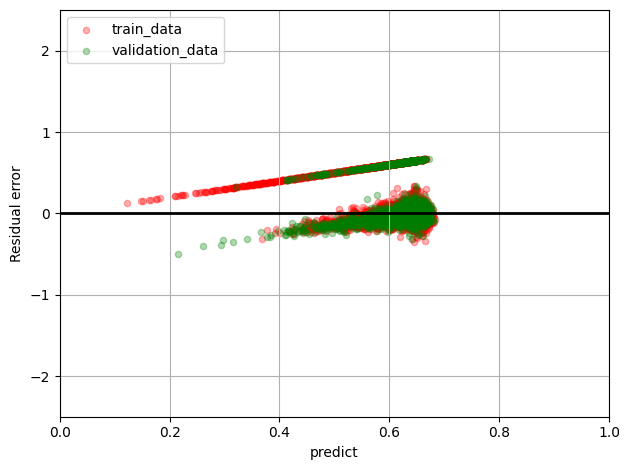

In [41]:
# 予測値と訓練データの残差をプロット
plt.scatter(y_pred_train,             # グラフのx値(予測値)を定義
            y_pred_train - y_train,   # グラフのy値(予測値と訓練データの差)を定義
            c='red',                 # プロットの色を指定
            marker='o',               # マーカーの種類
            s=20,                     # マーカーのサイズ
            alpha=0.3,                # グラフの透過度
            label='train_data')         # ラベル名


# 予測値とテストデータの残差をプロット
plt.scatter(y_pred_test,
            y_pred_test - y_valid,
            c='green',
            marker='o',
            s=20,
            alpha=0.3,
            label='validation_data')

# グラフの詳細設定を行う
plt.xlabel('predict')
plt.ylabel('Residual error')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-20, xmax=20, lw=2, color='black')
plt.xlim([0, 1])
plt.ylim([-2.5, 2.5])
plt.tight_layout()
plt.grid(True)
plt.show()